# Import library

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# 배경색 흰색으로 맞춰줌
import matplotlib as mpl
mpl.rc('figure', facecolor = 'w', edgecolor ='w')

# Preprocessing

### Load Data

In [171]:
# Data Load
demo = pd.read_csv('./data/LPOINT_BIG_COMP_01_DEMO.csv', low_memory=False)
pdde = pd.read_csv('./data/LPOINT_BIG_COMP_02_PDDE.csv', low_memory=False)
cop = pd.read_csv('./data/LPOINT_BIG_COMP_03_COP_U.csv', low_memory=False)
clac = pd.read_csv('./data/LPOINT_BIG_COMP_04_PD_CLAC.csv', low_memory=False)
br = pd.read_csv('./data/LPOINT_BIG_COMP_05_BR.csv', low_memory=False)
lpay = pd.read_csv('./data/LPOINT_BIG_COMP_06_LPAY.csv', low_memory=False)

# Column명 변경
demo.columns = ['고객번호', '성별', '연령대', '거주지대분류코드']
pdde.columns = ['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '구매시간', '구매금액', '구매수량']
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '이용일자', '방문일자', '이용시간', '이용금액']
clac.columns = ['상품코드', '소분류명', '대분류명', '중분류명']
br.columns = ['점포코드', '제휴사', '점포대분류코드', '점포중분류코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '이용일자', '이용시간', '이용금액']

### Data Preprocessing

- 가독성을 위하여 불필요한 데이터 확인과정 삭제

####  [2. pdde]: 상품 구매 정보

In [172]:
# 중복되는 행 제거 -> 데이터 추출시 고객, 상품 각각 추출하여 중복이 발생한 것으로 판단함
pdde.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

# 결측치 치환 -> na값을 온라인으로 채워줌
pdde['점포코드'] = pdde['점포코드'].fillna('온라인')

#### [3. cop]: 제휴사 이용 정보

In [173]:
# 결측치 치환
cop['점포코드'] = cop['점포코드'].fillna('온라인')

# Data Merge

In [174]:
# 데이터를 통합하기 위하여 칼럼 통합
pdde['타입'] = 'Product'
cop['타입'] = 'Affiliate'
lpay['타입'] = 'Lpay'
pdde['방문일자'] = 0
lpay['방문일자'] = 0
cop['구매수량'] = 0
cop['상품코드'] = np.nan
lpay['점포코드'] = np.nan
lpay['상품코드'] = np.nan
lpay['구매수량'] = 0

In [175]:
# 칼럼명을 새롭게 동일하게 통일
cop.columns = ['고객번호', '영수증번호', '제휴사', '점포코드', '채널구분', '구매일자', '방문일자', '구매시간', '구매금액', '타입', '구매수량', '상품코드']
lpay.columns = ['고객번호', '영수증번호', '제휴사', '채널구분', '구매일자', '구매시간', '구매금액', '타입', '방문일자', '점포코드', '상품코드', '구매수량']

# 상품구매데이터를 기준으로 하여 열을 통일
cop = cop[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]
lpay = lpay[['고객번호', '영수증번호', '채널구분', '제휴사', '점포코드', '상품코드', '구매일자', '방문일자', '구매시간', '구매금액', '구매수량', '타입']]

# 데이터 타입 변경
lpay['영수증번호'] = lpay['영수증번호'].astype('object')
lpay['점포코드'] = lpay['점포코드'].astype('object')
cop['상품코드'] = cop['상품코드'].astype('object')
lpay['상품코드'] = lpay['상품코드'].astype('object')
pdde['구매금액'] = pdde['구매금액'].astype('int')
pdde['방문일자'] = pdde['방문일자'].astype('int64')
lpay['방문일자'] = lpay['방문일자'].astype('int64')

In [176]:
# 데이터 concat
df = pd.concat([pdde,cop,lpay])
# 고객 정보 테이븛 통합
df = pd.merge(df, demo, on = ['고객번호'], how = 'left')
# 상품 분류 테이블 통합
df = pd.merge(df, br, on = ['점포코드','제휴사'], how = 'left')
# 점포 정보 테이블 통합
df = pd.merge(df, clac, on = ['상품코드'], how = 'left')

In [177]:
# 결측치 확인 -> 데이터를 합치면서 생기는 결측치만 존재
df.isnull().sum()

고객번호             0
영수증번호            0
채널구분             0
제휴사              0
점포코드        353184
상품코드        601488
구매일자             0
구매시간             0
구매금액             0
구매수량             0
타입               0
방문일자             0
성별               0
연령대              0
거주지대분류코드         0
점포대분류코드     729023
점포중분류코드     729023
소분류명        601488
대분류명        601488
중분류명        601488
dtype: int64

## Train Test Split

In [178]:
# 날짜로 변경
df['날짜'] = df['구매일자'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])
# 각 거래일간의 차이를 구함
df = df.sort_values(by=['날짜'], ascending=[True])
df['diff'] = df.groupby('고객번호')['날짜'].diff().fillna('0').astype(str)
df['diff'] = df['diff'].apply(lambda x: int(x.split()[0]))
# 데이터를 거래횟수별로 나누기 위한 작업
imp = df.groupby('고객번호')['영수증번호'].apply(set).reset_index()
imp['거래횟수'] = imp['영수증번호'].apply(lambda x:len(list(x)))
# 뉴비와 올드비를 구분해줌
oldbie = imp[imp['거래횟수']>3]['고객번호'].tolist()
newbie = imp[imp['거래횟수']<=3]['고객번호'].tolist()

# 데이터 분리
df_old = df[df['고객번호'].isin(oldbie)]
df_new = df[df['고객번호'].isin(newbie)]

In [179]:
imp['거래횟수'].describe()

count    29874.000000
mean        62.531867
std         82.834860
min          1.000000
25%         11.000000
50%         36.000000
75%         81.000000
max       4215.000000
Name: 거래횟수, dtype: float64

In [180]:
df_old.고객번호.nunique(), df_new.고객번호.nunique()

(26212, 3662)

# RFM

In [181]:
customer_id = df_old.groupby('고객번호')[['구매일자']].max().index.tolist()
recency = df_old.groupby('고객번호')[['구매일자']].max()['구매일자'].tolist()
freq = df_old.groupby('고객번호')['영수증번호'].apply(set).reset_index()
frequency = freq['영수증번호'].apply(lambda x:len(list(x)))
monetary = df_old.groupby('고객번호')[['구매금액']].sum()['구매금액'].tolist()

df_rfm = pd.DataFrame({'Customer_ID': customer_id, 'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [182]:
df_rfm['Recency'] = df_rfm['Recency'].astype(str)
df_rfm['Recency'] = pd.to_datetime(df_rfm['Recency'])
df_rfm['Recency'] = df_rfm['Recency'] - pd.to_datetime('20210101')
# df_rfm['Recency'] = [x.total_seconds() for x in df_rfm['Recency']]

df_rfm['Recency'] = df_rfm['Recency'].dt.days # days로
df_rfm

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,356,13,616240
1,M000136117,363,89,28697031
2,M000201112,331,5,51420
3,M000225114,364,88,2084270
4,M000261625,337,49,6072050
...,...,...,...,...
26207,M999673157,351,17,2851370
26208,M999770689,364,216,2078770
26209,M999849895,334,35,1095312
26210,M999926092,335,7,129500


# Data Clustering

- k-means를 위한 Scaling

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import time
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [184]:
scaler = StandardScaler()
scaler.fit(df_rfm.iloc[:,1:])

StandardScaler()

In [185]:
rfm_scaled = scaler.transform(df_rfm.iloc[:,1:]) 

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns = df_rfm.iloc[:,1:].columns) 
rfm_scaled_df.insert(0, 'Customer_ID', df_rfm['Customer_ID'])
rfm_scaled_df

,Customer_ID,Recency,Frequency,Monetary
0,M000034966,0.388787,-0.682454,-0.292294
1,M000136117,0.549046,0.211318,1.677066
2,M000201112,-0.183566,-0.776535,-0.331906
3,M000225114,0.571940,0.199558,-0.189339
4,M000261625,-0.046201,-0.259088,0.090332
...,...,...,...,...
26207,M999673157,0.274316,-0.635413,-0.135540
26208,M999770689,0.571940,1.704857,-0.189724
26209,M999849895,-0.114884,-0.423730,-0.258696
26210,M999926092,-0.091990,-0.753015,-0.326430


- Clustering

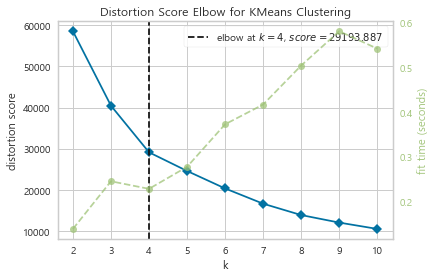

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [186]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled_df.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수 확인

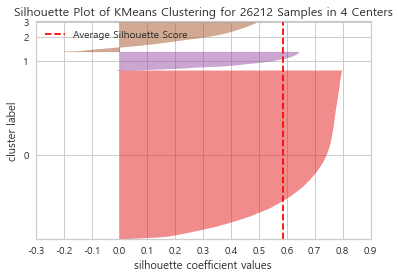

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26212 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [187]:
model_4clust = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))

sil_visualizer = SilhouetteVisualizer(model_4clust)
sil_visualizer.fit(rfm_scaled_df.iloc[:,1:])
sil_visualizer.show()

- 군집 라벨링

In [188]:
kmeans = KMeans(n_clusters = 4, random_state=np.random.RandomState(seed=42))
labels = kmeans.fit_predict(rfm_scaled_df.iloc[:,1:])

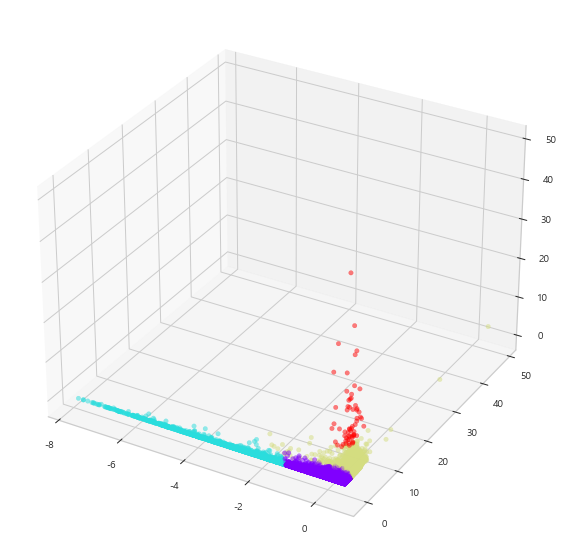

In [189]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled_df['Recency']
y = rfm_scaled_df['Frequency']
z = rfm_scaled_df['Monetary']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

In [190]:
rfm_scaled_df['labels'] = labels
rfm_df = rfm_scaled_df[['Customer_ID', 'labels']]
rfm_df.columns = ['고객번호', 'labels']
rfm_df.head(3)

,고객번호,labels
0,M000034966,0
1,M000136117,2
2,M000201112,0


- data merge

In [191]:
df_old = pd.merge(df_old, rfm_df, on = ['고객번호'], how = 'left')
df_old.head(3)

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,연령대,거주지대분류코드,점포대분류코드,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,40대,Z10,Z17,Z17011,NaN,NaN,NaN,2020-12-27,0,0
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,40대,Z06,Z06,Z06013,NaN,NaN,NaN,2020-12-29,0,2
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,40대,Z10,Z10,Z10011,NaN,NaN,NaN,2020-12-29,0,0


- train_test_split

In [192]:
from sklearn.model_selection import train_test_split

In [193]:
rfm_df = pd.merge(rfm_df, demo[demo['고객번호'].isin(oldbie)].reset_index(drop=True), how='inner',on='고객번호')

In [194]:
# 열 순서 변경
rfm_df = rfm_df[['고객번호', '성별', '연령대', '거주지대분류코드', 'labels']]

## 파생변수 생성

- 영수증 번호의 길이

In [195]:
# 영수증 번호의 길이가 12, 15, 18 3가지로 나누어지는데 이는 각 다른 점포에서 결제한 것을 의미할 것이라고 판단하여 새로운 파생변수로 생성
df_old['영수증번호길이'] = df_old['영수증번호'].apply(lambda x: len(str(x)))
df_old['영수증번호길이'].value_counts()

12    4134942
15     353002
18     245778
Name: 영수증번호길이, dtype: int64

In [196]:
df_old.groupby('영수증번호길이')['구매금액'].mean()

영수증번호길이
12    23943.214323
15    60764.327964
18    20119.587070
Name: 구매금액, dtype: float64

In [197]:
rfm_df['영수증번호길이평균'] = df_old.groupby('고객번호')[['영수증번호길이']].mean()['영수증번호길이'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균
0,M000034966,여성,40대,Z07,0,12.122449
1,M000136117,여성,30대,Z11,2,12.842975
2,M000201112,여성,50대,Z17,0,12.000000
3,M000225114,여성,40대,Z17,0,12.368098
4,M000261625,여성,40대,Z17,0,12.089552
...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000
26208,M999770689,여성,30대,Z16,2,12.813433
26209,M999849895,여성,20대,Z04,0,12.085714
26210,M999926092,남성,30대,Z08,0,18.000000


- 영수증의 타입

In [198]:
# 영수증 번호의 타입을 생성하는 함수
def receipt_type(x):
    if len(str(x)) == 18:
        return str(x)[8]
    elif len(str(x)) == 15:
        return 'number'
    elif len(str(x)) == 12:
        return str(x)[0]

In [199]:
# 영수증마다 하나의 영어를 포함하거나, 모두 숫자로 이루어져있기 때문에 이러한 타입을 나타내는 파생변수를 생성
df_old['영수증타입'] = df_old['영수증번호'].apply(receipt_type)
df_old['영수증타입'].value_counts()

A         3760036
E          381115
number     353002
D          154419
C           77108
B            8042
Name: 영수증타입, dtype: int64

In [200]:
rfm_df['영수증타입최대값'] = df_old.groupby('고객번호')[['영수증타입']].max()['영수증타입'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값
0,M000034966,여성,40대,Z07,0,12.122449,D
1,M000136117,여성,30대,Z11,2,12.842975,number
2,M000201112,여성,50대,Z17,0,12.000000,A
3,M000225114,여성,40대,Z17,0,12.368098,D
4,M000261625,여성,40대,Z17,0,12.089552,D
...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A
26208,M999770689,여성,30대,Z16,2,12.813433,number
26209,M999849895,여성,20대,Z04,0,12.085714,D
26210,M999926092,남성,30대,Z08,0,18.000000,D


- 최대 구매 경로

In [201]:
df_old['채널구분'].value_counts()

1    4122105
2     611617
Name: 채널구분, dtype: int64

In [202]:
def buy_root(x):
    if x == 1:
        return '오프라인'
    elif x == 2:
        return '온라인'

In [203]:
rfm_df['최다구매경로'] = df_old.groupby('고객번호')[['채널구분']].max()['채널구분'].tolist()
rfm_df['최다구매경로'] = rfm_df['최다구매경로'].apply(buy_root)
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인
...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인


- 제휴사의 타입

In [204]:
# 제휴사의 제일 앞에 알파벳의 경우에는 제휴사의 타입을 나타낼 수 있기 때문에 파생변수로 생성
df_old['제휴사타입'] = df_old['제휴사'].apply(lambda x: str(x)[0])
df_old['제휴사타입'].value_counts()

A    4362804
D     171769
L      93429
C      90236
B       8811
E       6673
Name: 제휴사타입, dtype: int64

In [205]:
rfm_df['최다제휴사타입'] = df_old.groupby('고객번호')[['제휴사타입']].max()['제휴사타입'].tolist()
rfm_df['최다제휴사'] = df_old.groupby('고객번호')[['제휴사']].max()['제휴사'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01
...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02


In [206]:
df_old

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,점포중분류코드,소분류명,대분류명,중분류명,날짜,diff,labels,영수증번호길이,영수증타입,제휴사타입
0,M495972460,20122713C012328716,2,C01,C010004,NaN,20201227,13,26000,0,...,Z17011,NaN,NaN,NaN,2020-12-27,0,0,18,C,C
1,M039320884,20122911C011862577,2,C01,C010117,NaN,20201229,11,6500,0,...,Z06013,NaN,NaN,NaN,2020-12-29,0,2,18,C,C
2,M192531170,20122900C013317930,2,C01,C010026,NaN,20201229,0,10000,0,...,Z10011,NaN,NaN,NaN,2020-12-29,0,0,18,C,C
3,M864132607,20123021C013512700,2,C01,C010086,NaN,20201230,21,15000,0,...,Z14004,NaN,NaN,NaN,2020-12-30,0,0,18,C,C
4,M577916024,20123012C012610437,2,C01,C010102,NaN,20201230,12,16000,0,...,Z16015,NaN,NaN,NaN,2020-12-30,0,0,18,C,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733717,M593010408,A03159704778,1,A03,A030337,PD0232,20211231,15,3990,1,...,Z17018,일반스낵,과자,스낵류,2021-12-31,0,0,12,A,A
4733718,M593010408,A03159704778,1,A03,A030337,PD1333,20211231,15,2550,2,...,Z17018,일반소주,주류,소주,2021-12-31,0,0,12,A,A
4733719,M593010408,A03159704778,1,A03,A030337,PD1343,20211231,15,1390,2,...,Z17018,막걸리,주류,전통주,2021-12-31,0,0,12,A,A
4733720,M714979893,A03158123233,1,A03,A030331,PD1249,20211231,12,3600,1,...,Z17018,기타냉장조리,조리식품,냉장조리,2021-12-31,0,2,12,A,A


- 상품코드와 점포코드의 경우는 파생변수 생성 보류

- 구매일자관련 파생변수

In [207]:
df_old['구매일자'] = pd.to_datetime(df_old['구매일자'].astype(str))
df_old['구매년도'] = df_old['구매일자'].dt.year
df_old['구매월'] = df_old['구매일자'].dt.month
df_old['구매일'] = df_old['구매일자'].dt.day
df_old['구매요일'] = df_old['구매일자'].dt.weekday
df_old

,고객번호,영수증번호,채널구분,제휴사,점포코드,상품코드,구매일자,구매시간,구매금액,구매수량,...,날짜,diff,labels,영수증번호길이,영수증타입,제휴사타입,구매년도,구매월,구매일,구매요일
0,M495972460,20122713C012328716,2,C01,C010004,NaN,2020-12-27,13,26000,0,...,2020-12-27,0,0,18,C,C,2020,12,27,6
1,M039320884,20122911C011862577,2,C01,C010117,NaN,2020-12-29,11,6500,0,...,2020-12-29,0,2,18,C,C,2020,12,29,1
2,M192531170,20122900C013317930,2,C01,C010026,NaN,2020-12-29,0,10000,0,...,2020-12-29,0,0,18,C,C,2020,12,29,1
3,M864132607,20123021C013512700,2,C01,C010086,NaN,2020-12-30,21,15000,0,...,2020-12-30,0,0,18,C,C,2020,12,30,2
4,M577916024,20123012C012610437,2,C01,C010102,NaN,2020-12-30,12,16000,0,...,2020-12-30,0,0,18,C,C,2020,12,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733717,M593010408,A03159704778,1,A03,A030337,PD0232,2021-12-31,15,3990,1,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733718,M593010408,A03159704778,1,A03,A030337,PD1333,2021-12-31,15,2550,2,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733719,M593010408,A03159704778,1,A03,A030337,PD1343,2021-12-31,15,1390,2,...,2021-12-31,0,0,12,A,A,2021,12,31,4
4733720,M714979893,A03158123233,1,A03,A030331,PD1249,2021-12-31,12,3600,1,...,2021-12-31,0,2,12,A,A,2021,12,31,4


- 구매년도

In [208]:
rfm_df['최다구매년도'] = df_old.groupby('고객번호')[['구매년도']].max()['구매년도'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021
...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021


- 구매월

In [209]:
rfm_df['구매월평균'] = df_old.groupby('고객번호')[['구매월']].mean()['구매월'].tolist()
rfm_df['최다구매월'] = df_old.groupby('고객번호')[['구매월']].max()['구매월'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12


In [210]:
# 최다 구매 계절의 파생변수를 만들기 위해 계절을 나누는 파생변수 생성
def season(x):
    if x >= 3 and x <= 5:
        return '봄'
    elif x >= 6 and x <= 7:
        return '여름'
    elif x >= 8 and x <= 11:
        return '가을'
    else:
        return '겨울'

In [211]:
df_old['구매계절'] = df_old['구매월'].apply(season)
rfm_df['최다구매계절'] = df_old.groupby('고객번호')[['구매계절']].max()['구매계절'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름


In [212]:
rfm_df['평균구매일'] = df_old.groupby('고객번호')[['구매일']].mean()['구매일'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름,20.959184
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름,13.958678
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름,18.850000
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름,13.981595
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름,9.611940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름,16.625000
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름,15.223881
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름,10.728571
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름,17.857143


In [213]:
# 요일을 만드는 파생변수 생성
def dayofweek(x):
    if x == 0:
        return '월요일'
    elif x == 1:
        return '화요일'
    elif x == 2:
        return '수요일'
    elif x == 3:
        return '목요일'
    elif x == 4:
        return '금요일'
    elif x == 5:
        return '토요일'
    elif x == 6:
        return '일요일'

In [214]:
df_old['구매요일'] = df_old['구매요일'].apply(dayofweek)
rfm_df['최다구매요일'] = df_old.groupby('고객번호')[['구매요일']].max()['구매요일'].tolist()
rfm_df


,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,최다구매요일
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름,20.959184,화요일
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름,13.958678,화요일
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름,18.850000,일요일
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름,13.981595,화요일
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름,9.611940,화요일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름,16.625000,화요일
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름,15.223881,화요일
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름,10.728571,화요일
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름,17.857143,화요일


In [215]:
def weekday(x):
    if x == '토요일' or x == '일요일':
        return '주말'
    else:
        return '주중'

In [216]:
df_old['주중주말여부'] = df_old['구매요일'].apply(weekday)
rfm_df['주중주말선호도'] = df_old.groupby('고객번호')[['주중주말여부']].max()['주중주말여부'].tolist()
rfm_df


,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,최다구매요일,주중주말선호도
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름,20.959184,화요일,주중
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름,13.958678,화요일,주중
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름,18.850000,일요일,주중
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름,13.981595,화요일,주중
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름,9.611940,화요일,주중
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름,16.625000,화요일,주중
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름,15.223881,화요일,주중
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름,10.728571,화요일,주중
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름,17.857143,화요일,주중


- 구매시간 관련 파생변수

In [217]:
rfm_df['평균구매시간'] = df_old.groupby('고객번호')[['구매시간']].mean()['구매시간'].tolist()
rfm_df['최다구매시간'] = df_old.groupby('고객번호')[['구매시간']].max()['구매시간'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,최다구매요일,주중주말선호도,평균구매시간,최다구매시간
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름,20.959184,화요일,주중,16.693878,21
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름,13.958678,화요일,주중,15.413223,22
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름,18.850000,일요일,주중,11.800000,22
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름,13.981595,화요일,주중,17.331288,20
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름,9.611940,화요일,주중,15.462687,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름,16.625000,화요일,주중,13.833333,22
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름,15.223881,화요일,주중,12.950249,23
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름,10.728571,화요일,주중,15.800000,21
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름,17.857143,화요일,주중,16.857143,22


In [218]:
def hour_type(x):
    if x < 6:
        return '새벽'
    elif x >= 6 and x < 12:
        return '오전'
    elif x < 18 and x >= 12:
        return '오후'
    else:
        return '저녁'

In [219]:
df_old['구매시간분류'] = df_old['구매시간'].apply(hour_type)
rfm_df['주구매시간분류'] = df_old.groupby('고객번호')[['구매시간분류']].max()['구매시간분류'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,최다구매년도,구매월평균,최다구매월,최다구매계절,평균구매일,최다구매요일,주중주말선호도,평균구매시간,최다구매시간,주구매시간분류
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,2021,7.591837,12,여름,20.959184,화요일,주중,16.693878,21,저녁
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,2021,5.553719,12,여름,13.958678,화요일,주중,15.413223,22,저녁
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,2021,7.850000,11,여름,18.850000,일요일,주중,11.800000,22,저녁
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,2021,6.975460,12,여름,13.981595,화요일,주중,17.331288,20,저녁
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,2021,6.701493,12,여름,9.611940,화요일,주중,15.462687,19,저녁
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,2021,7.291667,12,여름,16.625000,화요일,주중,13.833333,22,저녁
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,2021,6.465174,12,여름,15.223881,화요일,주중,12.950249,23,저녁
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,2021,7.185714,12,여름,10.728571,화요일,주중,15.800000,21,저녁
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,2021,6.000000,12,여름,17.857143,화요일,주중,16.857143,22,저녁


- 구매금액 관련 파생변수

In [220]:
rfm_df['평균구매금액'] = df_old.groupby('고객번호')[['구매금액']].mean()['구매금액'].tolist()
rfm_df['최대구매금액'] = df_old.groupby('고객번호')[['구매금액']].max()['구매금액'].tolist()
rfm_df['최소구매금액'] = df_old.groupby('고객번호')[['구매금액']].min()['구매금액'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,...,최다구매계절,평균구매일,최다구매요일,주중주말선호도,평균구매시간,최다구매시간,주구매시간분류,평균구매금액,최대구매금액,최소구매금액
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,...,여름,20.959184,화요일,주중,16.693878,21,저녁,12576.326531,65700,100
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,...,여름,13.958678,화요일,주중,15.413223,22,저녁,237165.545455,2612000,100
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,...,여름,18.850000,일요일,주중,11.800000,22,저녁,2571.000000,8000,20
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,...,여름,13.981595,화요일,주중,17.331288,20,저녁,12786.932515,129000,300
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,...,여름,9.611940,화요일,주중,15.462687,19,저녁,90627.611940,1160000,2600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,...,여름,16.625000,화요일,주중,13.833333,22,저녁,118807.083333,1673000,50
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,...,여름,15.223881,화요일,주중,12.950249,23,저녁,5171.069652,131200,50
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,...,여름,10.728571,화요일,주중,15.800000,21,저녁,15647.314286,269000,840
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,...,여름,17.857143,화요일,주중,16.857143,22,저녁,18500.000000,29100,10000


- 구매수량 관련 파생변수

In [221]:
rfm_df['평균구매수량'] = df_old.groupby('고객번호')[['구매수량']].mean()['구매수량'].tolist()
rfm_df['최대구매수량'] = df_old.groupby('고객번호')[['구매수량']].max()['구매수량'].tolist()
rfm_df['최소구매수량'] = df_old.groupby('고객번호')[['구매수량']].min()['구매수량'].tolist()
rfm_df['평균낱개구매금액'] = [(x/y) if y != 0 else 0 for x,y in zip(rfm_df['평균구매금액'], rfm_df['평균구매수량'])]
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,...,평균구매시간,최다구매시간,주구매시간분류,평균구매금액,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,...,16.693878,21,저녁,12576.326531,65700,100,1.224490,4,0,10270.666667
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,...,15.413223,22,저녁,237165.545455,2612000,100,0.884298,5,0,268196.551402
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,...,11.800000,22,저녁,2571.000000,8000,20,1.450000,4,1,1773.103448
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,...,17.331288,20,저녁,12786.932515,129000,300,1.073620,4,0,11910.114286
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,...,15.462687,19,저녁,90627.611940,1160000,2600,1.044776,3,0,86743.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,...,13.833333,22,저녁,118807.083333,1673000,50,1.166667,2,1,101834.642857
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,...,12.950249,23,저녁,5171.069652,131200,50,0.940299,5,0,5499.391534
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,...,15.800000,21,저녁,15647.314286,269000,840,1.657143,38,0,9442.344828
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,...,16.857143,22,저녁,18500.000000,29100,10000,0.000000,0,0,0.000000


In [222]:
rfm_df['구매품목수'] = df_old.groupby('고객번호')[['영수증번호']].count()['영수증번호'].tolist()
rfm_df

,고객번호,성별,연령대,거주지대분류코드,labels,영수증번호길이평균,영수증타입최대값,최다구매경로,최다제휴사타입,최다제휴사,...,최다구매시간,주구매시간분류,평균구매금액,최대구매금액,최소구매금액,평균구매수량,최대구매수량,최소구매수량,평균낱개구매금액,구매품목수
0,M000034966,여성,40대,Z07,0,12.122449,D,오프라인,D,D01,...,21,저녁,12576.326531,65700,100,1.224490,4,0,10270.666667,49
1,M000136117,여성,30대,Z11,2,12.842975,number,온라인,D,D01,...,22,저녁,237165.545455,2612000,100,0.884298,5,0,268196.551402,121
2,M000201112,여성,50대,Z17,0,12.000000,A,오프라인,A,A04,...,22,저녁,2571.000000,8000,20,1.450000,4,1,1773.103448,20
3,M000225114,여성,40대,Z17,0,12.368098,D,오프라인,D,D02,...,20,저녁,12786.932515,129000,300,1.073620,4,0,11910.114286,163
4,M000261625,여성,40대,Z17,0,12.089552,D,오프라인,D,D01,...,19,저녁,90627.611940,1160000,2600,1.044776,3,0,86743.571429,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26207,M999673157,남성,30대,Z10,0,12.000000,A,오프라인,A,A04,...,22,저녁,118807.083333,1673000,50,1.166667,2,1,101834.642857,24
26208,M999770689,여성,30대,Z16,2,12.813433,number,온라인,L,L00,...,23,저녁,5171.069652,131200,50,0.940299,5,0,5499.391534,402
26209,M999849895,여성,20대,Z04,0,12.085714,D,오프라인,D,D01,...,21,저녁,15647.314286,269000,840,1.657143,38,0,9442.344828,70
26210,M999926092,남성,30대,Z08,0,18.000000,D,온라인,D,D02,...,22,저녁,18500.000000,29100,10000,0.000000,0,0,0.000000,7


- 주구매 대분류, 중분류, 소분류

In [223]:
df_old['대분류명'].fillna('없음', inplace = True)
df_old['중분류명'].fillna('없음', inplace = True)
df_old['소분류명'].fillna('없음', inplace = True)

In [224]:
# Data Leakage로 인하여 임시적으로 제거
# rfm_df['주구매대분류'] = df_old.groupby('고객번호')[['대분류명']].max()['대분류명'].tolist()
# rfm_df['주구매중분류'] = df_old.groupby('고객번호')[['중분류명']].max()['중분류명'].tolist()
# rfm_df['주구매소분류'] = df_old.groupby('고객번호')[['소분류명']].max()['소분류명'].tolist()
# rfm_df

## Modeling

In [225]:
target = rfm_df['labels']
data = rfm_df.drop(columns='labels')

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
# 인덱스를 지워줌
x_train, x_test, y_train, y_test = x_train.reset_index(drop=True), x_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

- Preprocessing

In [226]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [227]:
# 범주형 변수와 수치형 변수를 분리
## train
cat_feature_tr = x_train.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_tr = x_train.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 

## test
cat_feature_te = x_test.iloc[:,1:].select_dtypes(include=['object']).columns.to_list()
num_feature_te = x_test.iloc[:,1:].select_dtypes(exclude='object').columns.to_list() 

In [228]:
len(cat_feature_tr), len(num_feature_tr)

(11, 15)

In [229]:
# # 라벨 인코딩 해줌
# encoder = LabelEncoder()
# encoded_cat_tr = []
# encoded_cat_te = []
# for f in cat_feature_tr:
#     encoder = encoder.fit(x_train[f])
#     encoded_cat_tr.append(pd.DataFrame(encoder.transform(x_train[f]),columns = [f])) # train
#     encoded_cat_te.append(pd.DataFrame(encoder.transform(x_test[f]),columns = [f]))	# test

# 합쳐줌
# cat_tr = pd.concat(encoded_cat_tr, axis = 1) # train
# cat_te = pd.concat(encoded_cat_te, axis = 1) # test

# x_train = pd.concat([x_train['고객번호'],cat_tr], axis=1)
# x_test = pd.concat([x_test['고객번호'],cat_te], axis=1)

In [230]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
# fit_transform은 train에만 사용하고 test에는 학습된 인코더에 fit만 해야한다
one_cat_tr = ohe.fit_transform(x_train[cat_feature_tr])
one_cat_te = ohe.transform(x_test[cat_feature_te])

cat_tr = pd.DataFrame(one_cat_tr, columns=ohe.get_feature_names_out()) # train
cat_te = pd.DataFrame(one_cat_te, columns=ohe.get_feature_names_out()) # test

In [231]:
x_train_imp = pd.concat([x_train['고객번호'], cat_tr], axis=1)
x_test_imp = pd.concat([x_test['고객번호'], cat_te], axis=1)

x_train = pd.concat([x_train_imp, x_train[num_feature_tr]], axis=1)
x_test = pd.concat([x_test_imp, x_test[num_feature_te]], axis=1)

In [232]:
x_train.shape, x_test.shape

((20969, 86), (5243, 86))

- predict

In [248]:
# from catboost import CatBoostClassifier
model = RandomForestClassifier(random_state=42)

score = np.mean(cross_val_score(model, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.7453251038486833

- Test dataset score 확인

In [249]:
model.fit(x_train.iloc[:,1:], y_train)
pred = model.predict(x_test.iloc[:,1:])

f1_score(y_test, pred, average='macro')

0.7799842909426408

Text(0, 0.5, 'feature importance')

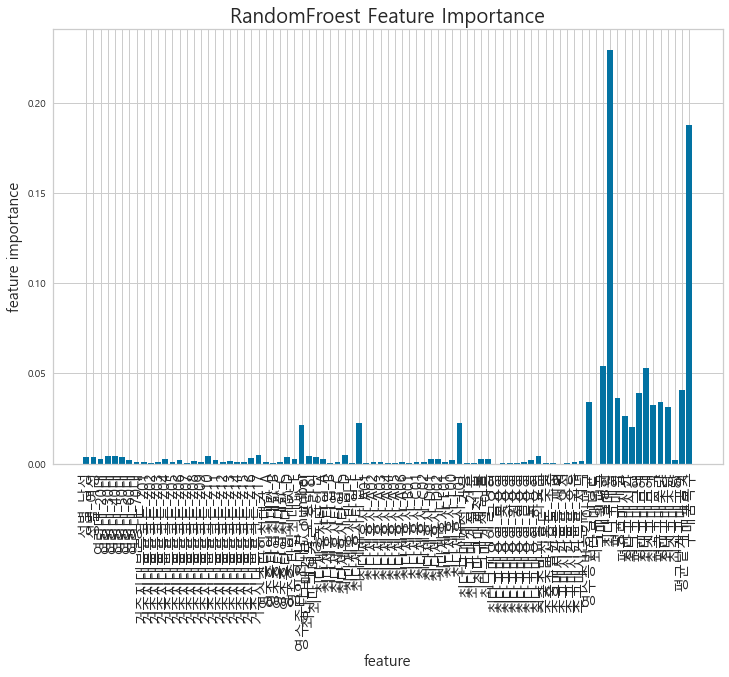

In [261]:
feature_name = list(x_train.columns)[1:]
n_feature = x_train.shape[1]-1
idx = np.arange(n_feature)

plt.figure(figsize=(12, 8))
plt.bar(idx, model.feature_importances_)
plt.title('RandomFroest Feature Importance', fontsize=20)
plt.xticks(rotation=90) #x축 값 세로로 변경
plt.xticks(idx, feature_name, fontsize=15)
plt.xlabel('feature', size=15)
plt.ylabel('feature importance', size=15)

In [268]:
sorted({x:y for x,y in zip(feature_name, model.feature_importances_)}.items(),key=lambda x: x[1])

[('최다구매년도', 0.0),
 ('주구매시간분류_새벽', 2.7190814538720847e-06),
 ('최다구매요일_금요일', 8.266300411027167e-05),
 ('주구매시간분류_오전', 0.00012821823436703),
 ('영수증타입최대값_B', 0.00014690909714701051),
 ('최다구매요일_목요일', 0.00016933591196094302),
 ('거주지대분류코드_Z02', 0.000229438853902413),
 ('최다제휴사_B01', 0.0002428157279604342),
 ('최다구매요일_수요일', 0.0002448973963120929),
 ('최다제휴사타입_B', 0.00026281862948244957),
 ('최다제휴사_A01', 0.0003417860081792236),
 ('거주지대분류코드_Z07', 0.00034943212071208345),
 ('주중주말선호도_주말', 0.0003677816314482664),
 ('최다제휴사_A05', 0.00042479399794289794),
 ('최다구매요일_월요일', 0.0004899104184346963),
 ('최다구매계절_가을', 0.0004901315611957786),
 ('주중주말선호도_주중', 0.0004974299193390116),
 ('최다구매계절_겨울', 0.0005053461700698362),
 ('최다제휴사_A04', 0.0005106258883194877),
 ('최다제휴사타입_E', 0.0006150088608023756),
 ('최다제휴사_E01', 0.0006881626600373933),
 ('최다제휴사_A03', 0.0007105017986681646),
 ('최다구매요일_일요일', 0.0007105849037698154),
 ('최다제휴사_C02', 0.0007485829453785316),
 ('영수증타입최대값_C', 0.000753371777880044),
 ('거주지대분류코드_Z01', 0.0007954

In [236]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(random_state=42, verbose=0)

score = np.mean(cross_val_score(model, x_train.iloc[:,1:], y_train, cv=5, scoring = 'f1_macro')) # 모델의 성능 확인 -> cv
score

0.8594604086013629

In [237]:
model.fit(x_train.iloc[:,1:], y_train)
pred = model.predict(x_test.iloc[:,1:])

f1_score(y_test, pred, average='macro')

0.8711548799716226

## END